In [1]:
import numpy as np
import cv2
print(cv2.__version__)
from matplotlib import pyplot as plt

4.5.4


In [2]:
def imshow(img):
    font = {'size': 16}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(20, 20))
    plt.imshow(img, cmap='gist_gray')

In [3]:
def kirsch_filter(img):
    kernels = [0] * 8
    kernels[0] = np.array(
        [[ 5, 5, 5], 
         [-3, 0,-3], 
         [-3,-3,-3]]
    )
    kernels[1] = np.array(
        [[-3, 5, 5], 
         [-3, 0, 5], 
         [-3,-3,-3]]
    )
    kernels[2] = np.array(
        [[-3,-3, 5], 
         [-3, 0, 5], 
         [-3,-3, 5]]
    )
    kernels[3] = np.array(
        [[-3,-3,-3], 
         [-3, 0, 5], 
         [-3, 5, 5]]
    )
    kernels[4] = np.array(
        [[-3,-3,-3], 
         [-3, 0,-3], 
         [ 5, 5, 5]]
    )
    kernels[5] = np.array(
        [[-3,-3,-3], 
         [ 5, 0,-3], 
         [ 5, 5,-3]]
    )
    kernels[6] = np.array(
        [[ 5,-3,-3], 
         [ 5, 0,-3], 
         [ 5,-3,-3]]
    )
    kernels[7] = np.array(
        [[ 5, 5,-3], 
         [ 5, 0,-3], 
         [-3,-3,-3]]
    )
    
    kirsch = cv2.filter2D(img, -1, kernels[0]) / 8
    for i in range(1, 8):
        kirsch += cv2.filter2D(img, -1, kernels[i]) / 8
    
    return kirsch

def sobel_filter(img):
    hkernel = np.array(
        [[-1, 0, 1], 
         [-2, 0, 2], 
         [-1, 0, 1]]
    )
    vkernel = np.array(
        [[-1,-2,-1], 
         [ 0, 0, 0], 
         [ 1, 2, 1]]
    )
    
    hsobel = cv2.filter2D(img, -1, hkernel)
    vsobel = cv2.filter2D(img, -1, vkernel)
    
    return hsobel / 2 + vsobel / 2

def laplas_filter(img):
    kernel = np.array(
        [[ 0, 1, 0], 
         [ 1,-4, 1], 
         [ 0, 1, 0]]
    )
    
    laplas = cv2.filter2D(img, -1, kernel)
    
    return laplas

def prewitt_filter3x3(img):
    hkernel = np.array(
        [[-1, 0, 1], 
         [-1, 0, 1], 
         [-1, 0, 1]]
    )
    vkernel = np.array(
        [[-1,-1,-1], 
         [ 0, 0, 0], 
         [ 1, 1, 1]]
    )
    
    hprewitt = cv2.filter2D(img, -1, hkernel)
    vprewitt = cv2.filter2D(img, -1, vkernel)
    
    return hprewitt / 2 + vprewitt / 2

def prewitt_filter4x4(img):
    hkernel = np.array(
        [[-3,-1, 1, 3], 
         [-3,-1, 1, 3], 
         [-3,-1, 1, 3],
         [-3,-1, 1, 3]]
    )
    vkernel = np.array(
        [[ 3, 3, 3, 3], 
         [ 1, 1, 1, 1], 
         [-1,-1,-1,-1],
         [-3,-3,-3,-3]]
    )
    
    hprewitt = cv2.filter2D(img, -1, hkernel)
    vprewitt = cv2.filter2D(img, -1, vkernel)
    
    return hprewitt / 2 + vprewitt / 2

In [4]:
rgb = cv2.imread('data/044.tif')[:,:,::-1]
rgb[:10,:,:] = 0
rgb[-10:,:,:] = 0
rgb[:,:10,:] = 0
rgb[:,-10:,:] = 0
hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV)
rgb.shape, hsv.shape

((702, 510, 3), (702, 510, 3))

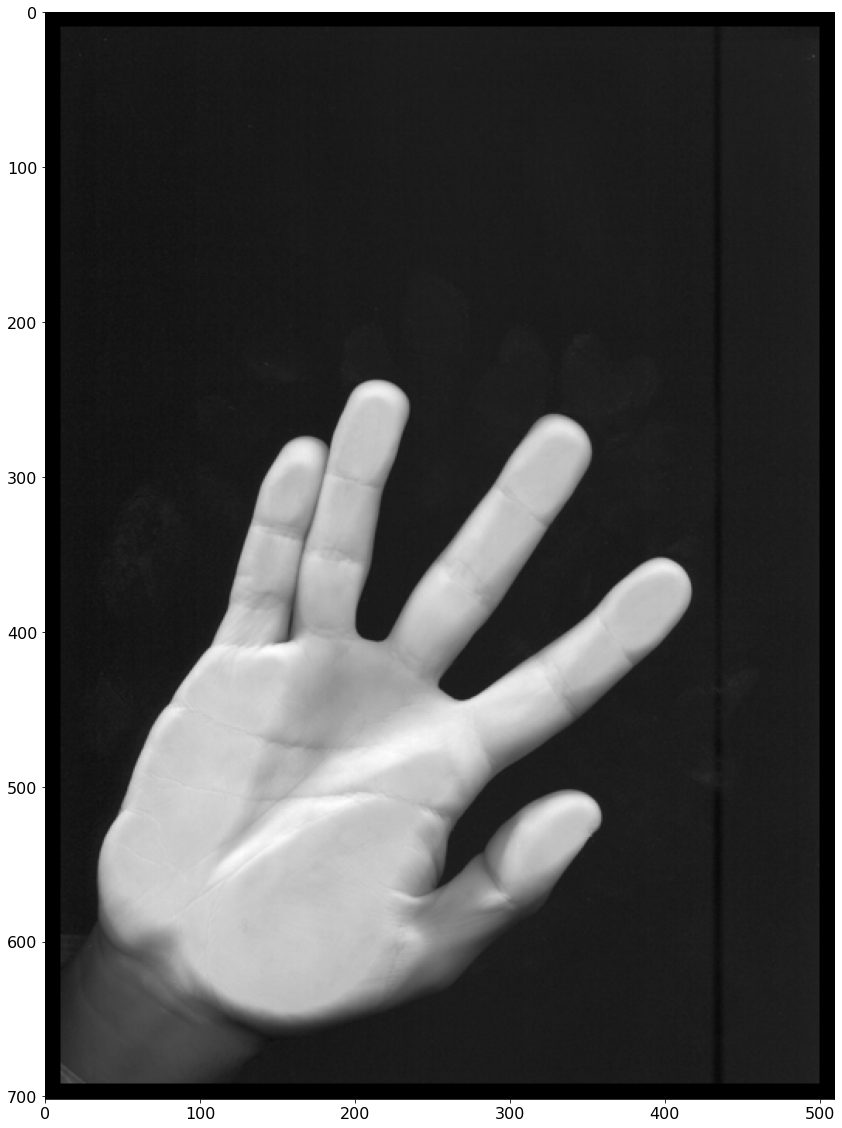

In [5]:
imshow(hsv[:,:,2])

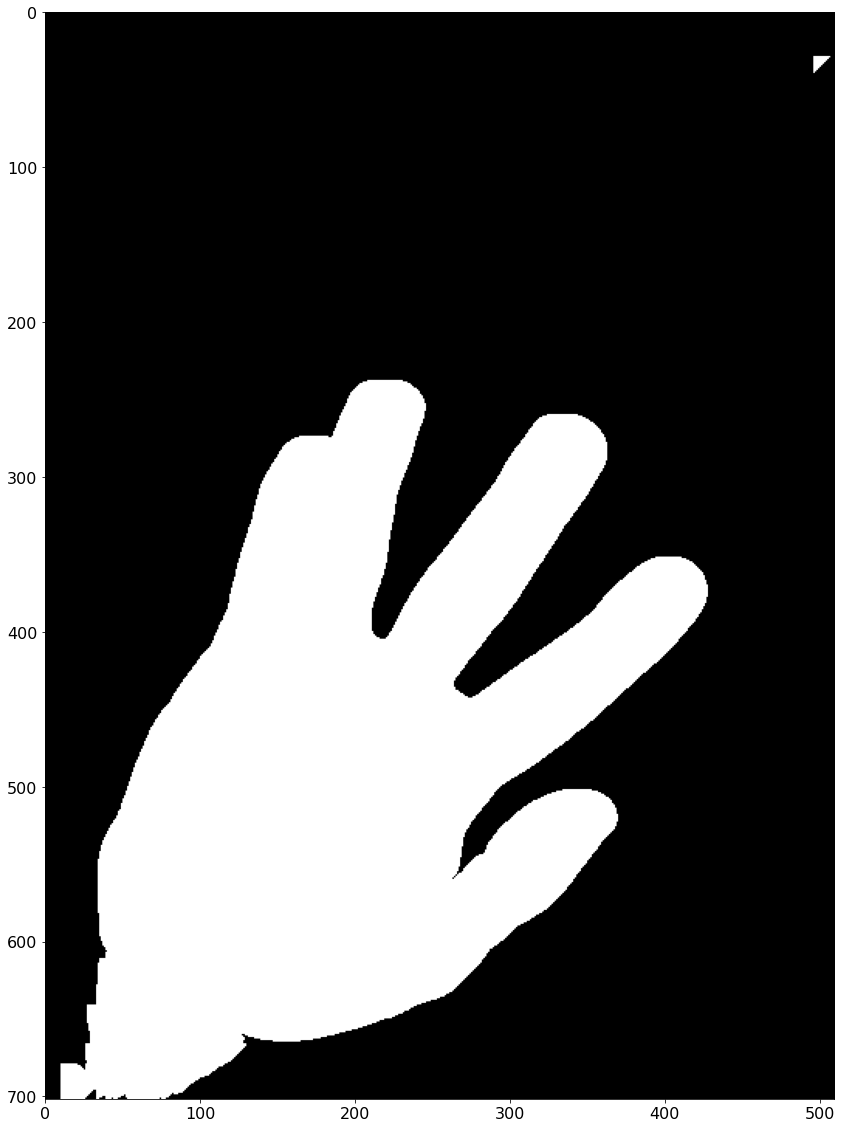

In [6]:
t, hand_mask = cv2.threshold(hsv[:,:,2], 60, 255, 0)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
hand_mask = cv2.morphologyEx(
    hand_mask, cv2.MORPH_DILATE, kernel, iterations=10
)

imshow(hand_mask)

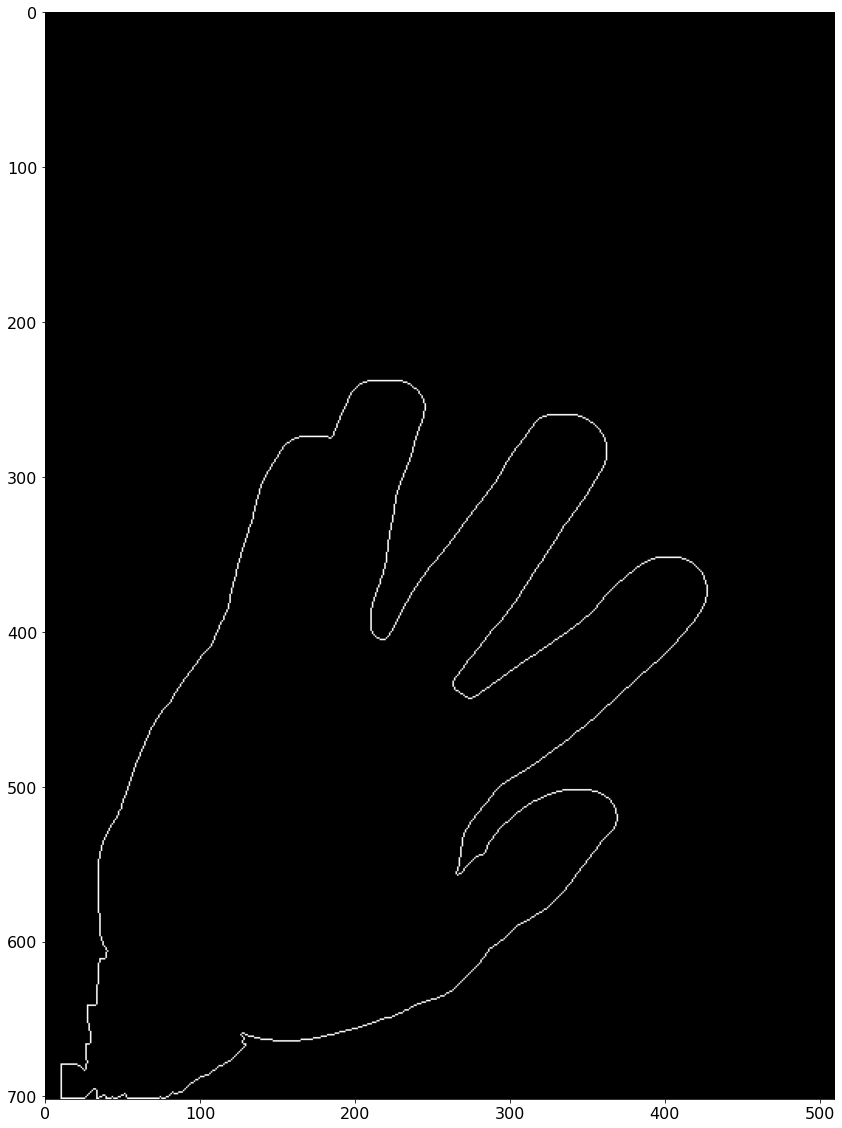

In [7]:
q1, q2 = cv2.findContours(
    hand_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
)

r = np.zeros(hand_mask.shape)
n = 0
for e1 in q1:
    if len(e1) < 1000:
        continue
    n += 1
    for e2 in e1:
        e2 = e2.reshape(-1)
        r[e2[1], e2[0]] = 255
r = r.astype(np.uint8)
        
imshow(r)

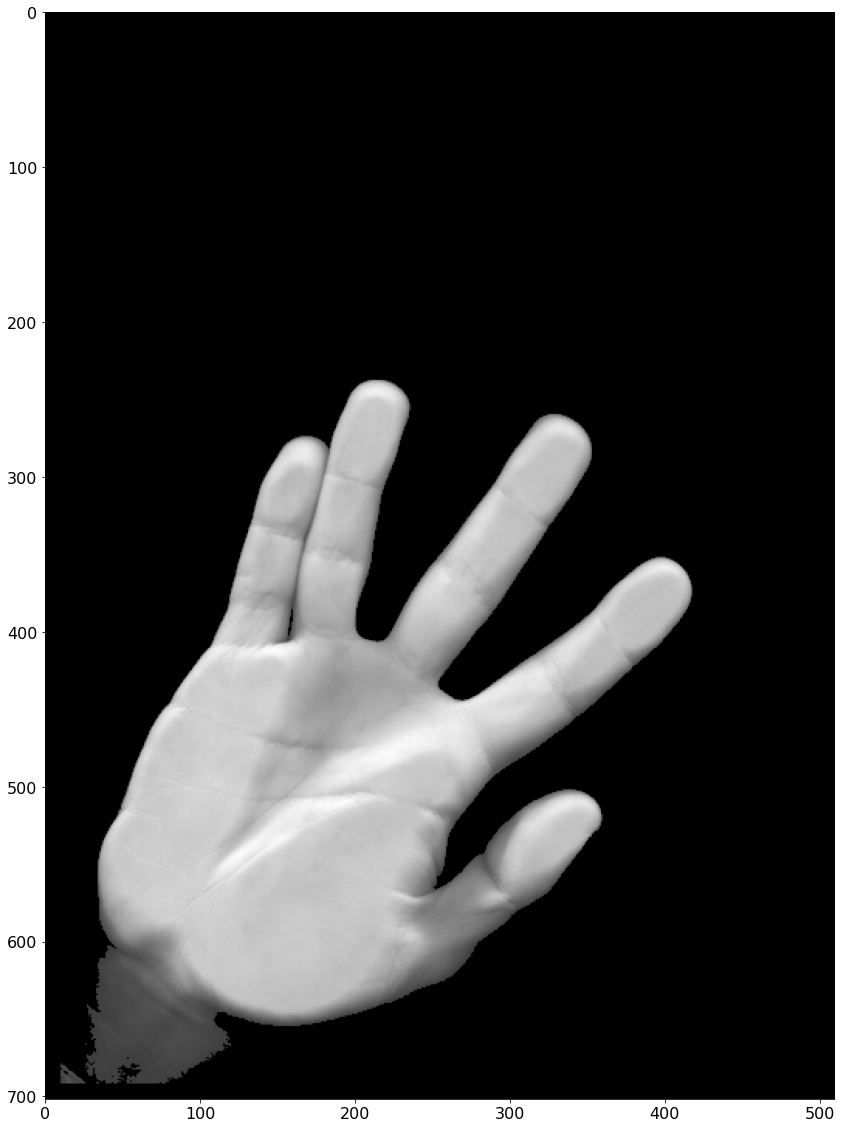

In [8]:
hand_mask = np.zeros(hand_mask.shape)
q1, q2 = cv2.findContours(
    r, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
)
cv2.fillPoly(hand_mask, pts=q1, color=(255, 255, 255))
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
hand_mask = cv2.morphologyEx(
    hand_mask, cv2.MORPH_DILATE, kernel, iterations=60
)
t, hand_mask = cv2.threshold(hand_mask * hsv[:,:,2] // 255, 60, 255, 0)

imshow(hand_mask * hsv[:,:,2] // 255)

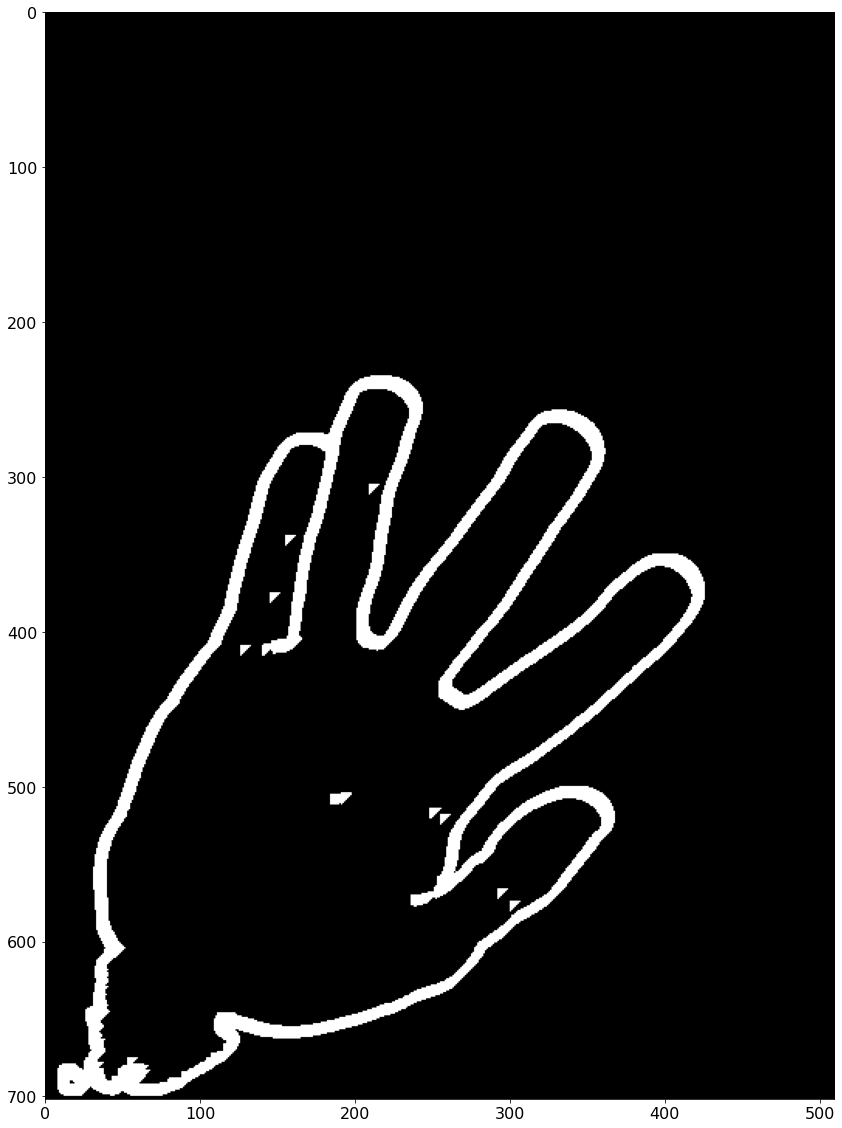

In [9]:
border_01 = cv2.adaptiveThreshold(
    (hand_mask * hsv[:,:,2] // 255).astype(np.uint8), 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY, 7, 15
)

border_01 = 255 - border_01

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))

# for i in range(10): #5
#     border_01 = cv2.medianBlur(border_01.astype(np.float32), 3)
#     border_01 = cv2.morphologyEx(
#         border_01, cv2.MORPH_DILATE, kernel, iterations=1
#     )

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
border_01 = cv2.morphologyEx(
    border_01, cv2.MORPH_DILATE, kernel, iterations=6
) 

imshow(border_01)

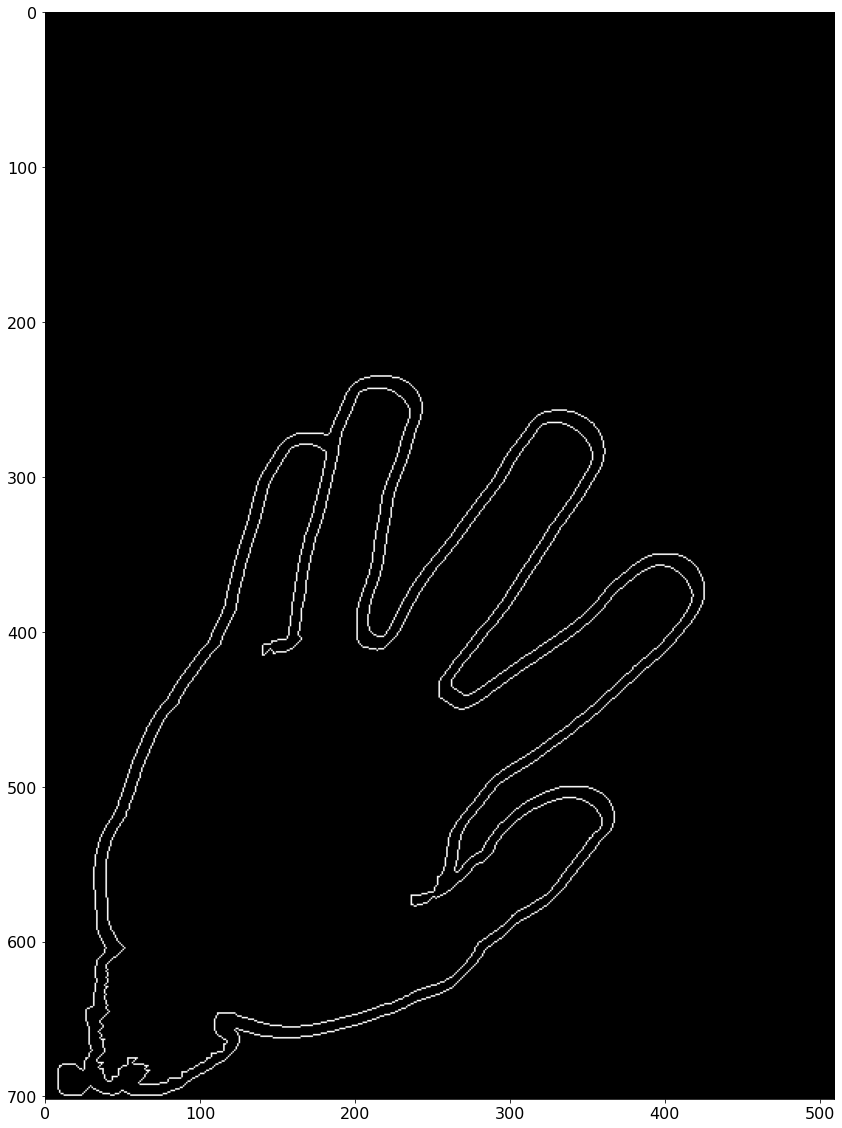

In [10]:
q1, q2 = cv2.findContours(
    border_01, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE
)

r = np.zeros(border_01.shape)
c = []
for e1 in q1:
    if len(e1) < 800:
        continue
    n += 1
    c.append(e1)
    for e2 in e1:
        e2 = e2.reshape(-1)
        r[e2[1], e2[0]] = 255
r = r.astype(np.uint8)

imshow(r)

In [11]:
contours = {}
if cv2.contourArea(c[0]) > cv2.contourArea(c[1]):
    contours['ex'] = c[0]
    contours['in'] = c[1]
else:
    contours['ex'] = c[1]
    contours['in'] = c[0]

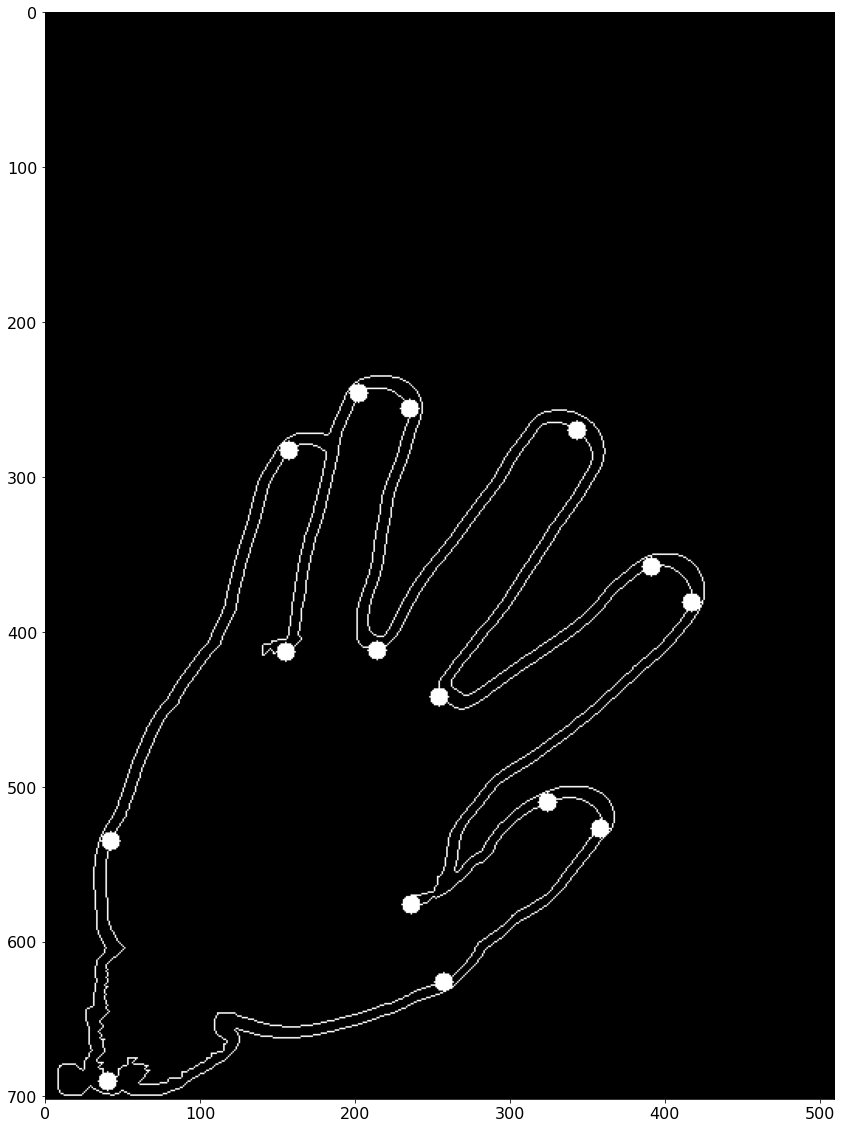

In [12]:
length = cv2.arcLength(contours['in'], True)
epsilon = (1/100)*length
approx = cv2.approxPolyDP(contours['in'], epsilon, True)
r2 = r.copy()
for p in approx:
    cv2.circle(r2, p[0], 6, 255, -1)

imshow(r2)

In [13]:
approx = approx[:,0,:]

In [14]:
approx

array([[343, 270],
       [254, 442],
       [391, 358],
       [417, 381],
       [236, 576],
       [324, 510],
       [358, 527],
       [257, 626],
       [ 40, 690],
       [ 42, 535],
       [157, 283],
       [155, 413],
       [202, 246],
       [235, 256],
       [214, 412]], dtype=int32)

In [15]:
contours['in'] = contours['in'][:,0,:]
contours['ex'] = contours['ex'][:,0,:]

In [16]:
contours['ex']
contours['in']

array([[207, 244],
       [208, 243],
       [209, 243],
       ...,
       [204, 245],
       [205, 244],
       [206, 244]], dtype=int32)

In [17]:
approx_idx = np.full(approx.shape[0], -1)
for i in range(len(contours['in'])):
    for j in range(len(approx)):
        if (contours['in'][i] == approx[j]).sum() == 2:
            approx_idx[j] = i
approx_idx

array([ 364,  536,  675,  712,  943, 1037, 1081, 1198, 1488, 1652, 1904,
       2087, 2256,   30,  193])

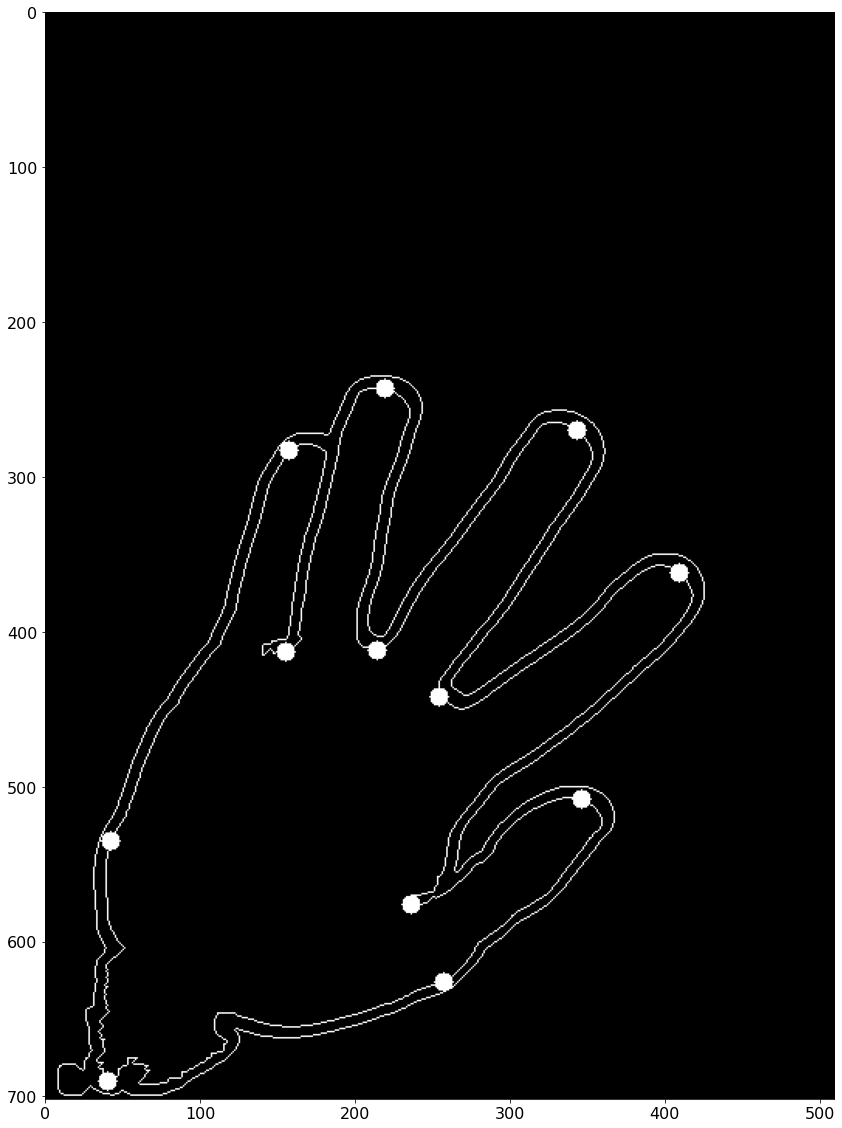

In [18]:
r3 = r.copy()
thr_01 = 80
thr_02 = 150
thr_abs = 50
for k in range(2):
    t = []
    fl2 = False
    for i in range(len(approx_idx)):
        if fl2:
            fl2 = False
            continue
        p1 = approx_idx[(i+1)%len(approx_idx)]
        p2 = approx_idx[(i)%len(approx_idx)]
        dist_abs = ((contours['in'][p1] - contours['in'][p2])**2).sum()**0.5
        if abs(p1 - p2) < len(contours['in']) - abs(p1 - p2):
            dist_contour = abs(p1 - p2)
            fl1 = True
        else:
            dist_contour = len(contours['in']) - abs(p1 - p2)
            fl1 = False

        if dist_contour <= thr_01:
            fl2 = True
            if fl1:
                t.append(int((p1 + p2) / 2))
            else:
                t.append(int((len(contours['in']) + p1 + p2) / 2) % len(contours['in']))
        elif dist_abs <= thr_abs and dist_contour <= thr_02:
            fl2 = True
            if fl1:
                t.append(int((p1 + p2) / 2))
            else:
                t.append(int((len(contours['in']) + p1 + p2) / 2) % len(contours['in']))
        else:
            t.append(p2)
    approx_idx = np.array(t)
            
approx = np.sort(np.array(approx_idx))
for k, i in enumerate(approx):
    cv2.circle(r3, contours['in'][i], 6, 255, -1)

imshow(r3)

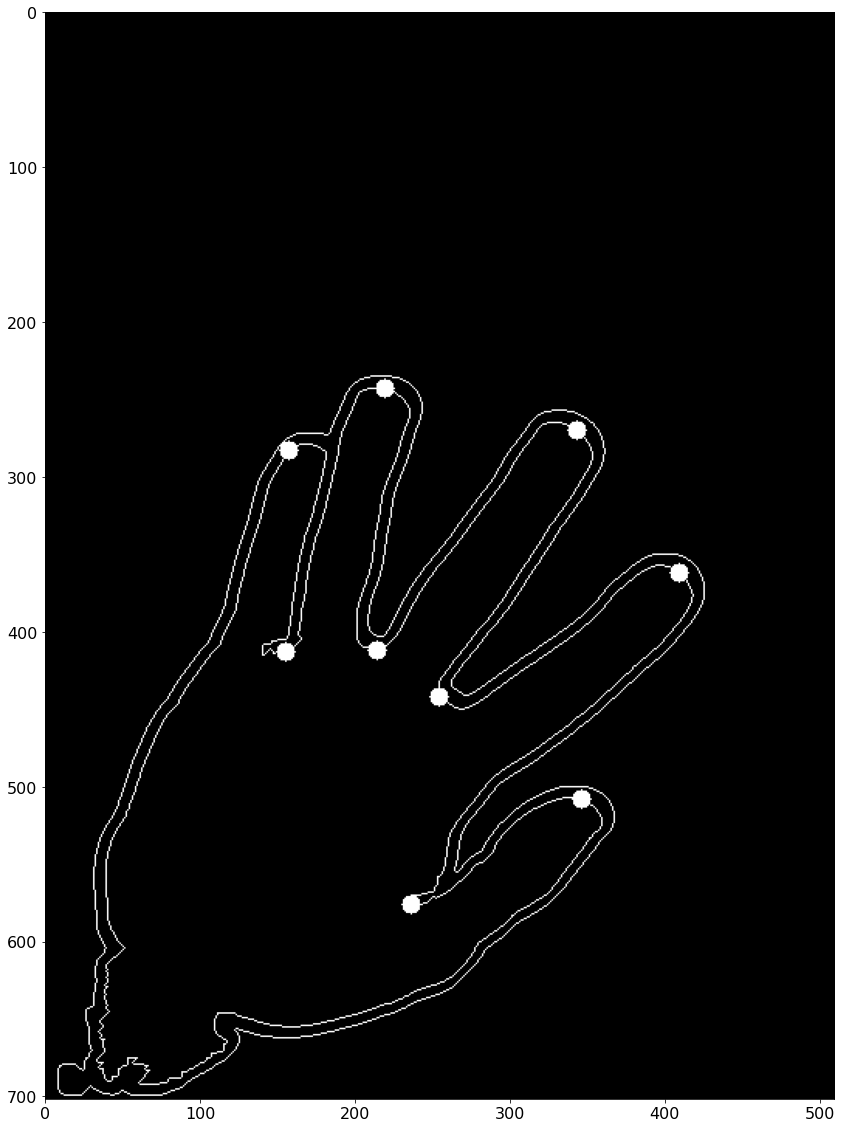

In [19]:
def angle(p1, p2, p3):
    v1 = p1 - p2
    v2 = p3 - p2
    l1 = np.sqrt(v1.dot(v1))
    l2 = np.sqrt(v2.dot(v2))
    angle = np.arccos(v1.dot(v2) / (l1 * l2))
    return angle * 57.3

t = []
for i in range(len(approx)):
    p1 = contours['in'][(approx[(i-1) % len(approx)])]
    p2 = contours['in'][(approx[(i) % len(approx)])]
    p3 = contours['in'][(approx[(i+1) % len(approx)])]
    ang = angle(p1, p2, p3)
    t.append(ang < 100)
    
t = np.array(t)
tt = np.concatenate([t, t])
m = np.array([True] * 9)
first_p = -1
for i in range(t.shape[0]):
    if (tt[i:i+9] == m).sum() == 9:
        first_p = i % t.shape[0]
#         break

a = []
for i in range(first_p, first_p+9):
    if t[i % len(approx)]:
        a.append(contours['in'][approx[i%len(approx)]])

r4 = r.copy()
for p in a:
    cv2.circle(r4, p, 6, 255, -1)

imshow(r4)

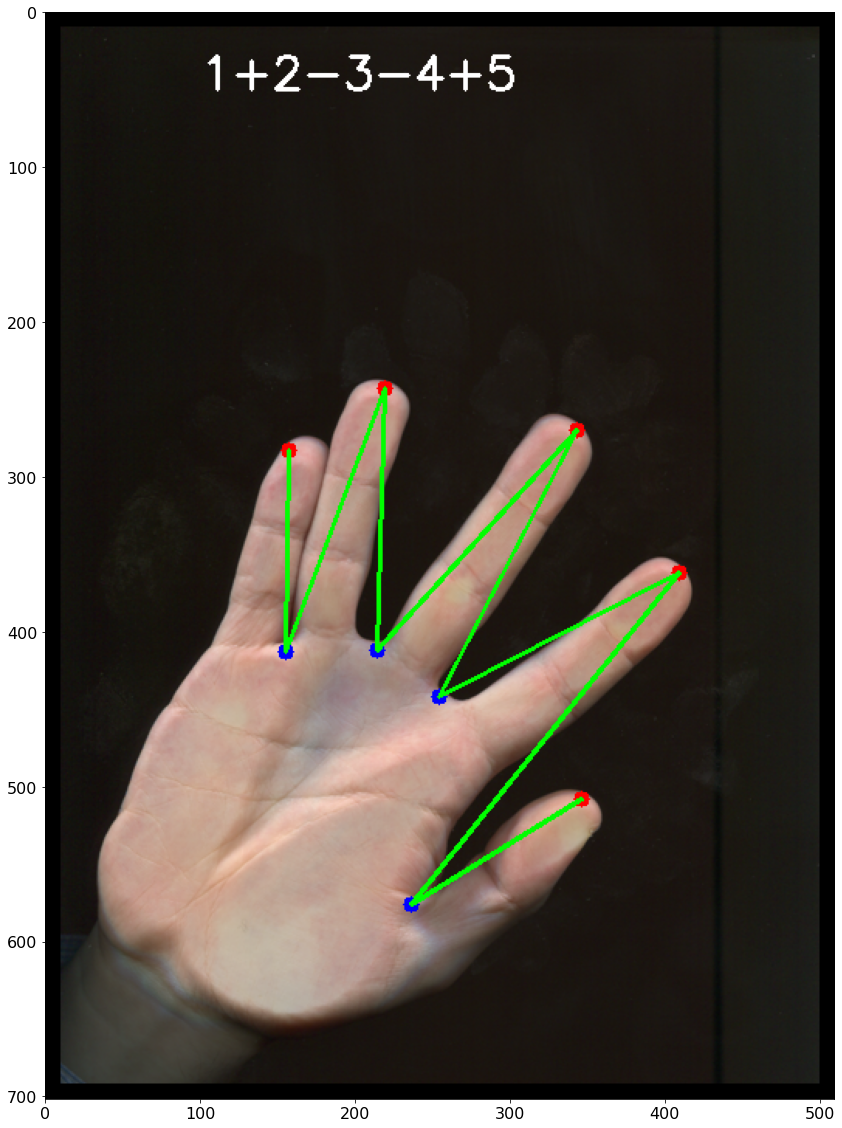

In [20]:
r5 = rgb.copy()
for i in range(len(a)):
    if i % 2 == 0:
        cv2.circle(r5, a[i], 5, (255, 0, 0), -1)
    else:
        cv2.circle(r5, a[i], 5, (0, 0, 255), -1)

for i in range(len(a)-1):
    cv2.line(r5, a[i], a[i+1], (0, 255, 0), thickness=2)
    
angles = []
for i in range(1, len(a), 2):
    angles.append(angle(a[i-1], a[i], a[i+1]))

thr_angle = [30, 20, 25, 35]

text = '5'
for i in range(4):
    if angles[i] < thr_angle[i]:
        text = '+' + text
    else:
        text = '-' + text
    text = str(5 - 1 - i) + text
    
cv2.putText(
    r5, text, (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 
    1, (255, 255, 255), 2
)

imshow(r5)